### Working Pansharpening Algorithm

In [1]:
# !conda update -n base -c defaults conda

In [2]:
import quality
import wald
import pansharpening
import importlib
import pandas as pd
import cv2
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import plot, hist, enhance

In [3]:
# Loading the images
Bs = glob("Images/*.tif")
B = cv2.imread(Bs[3], 0)
G = cv2.imread(Bs[4], 0)
R = cv2.imread(Bs[5], 0)

# PAN & BGR bands (full size)
PAN = cv2.imread(Bs[9], 0)
BGR_lowres = np.stack((B, G, R), -1)

# Cropping the bands
mask = {"y1":2300, "y2":2600, "x1":4000, "x2":4300}
PAN = PAN[mask["y1"]:mask["y2"], mask["x1"]:mask["x2"]]
mask = {k:int(mask[k]/2) for k in mask}
BGR_lowres = BGR_lowres[mask["y1"]:mask["y2"], mask["x1"]:mask["x2"]]

# Running all pansharpening methods on the images
panned = []
panned_names = []
panned_results = []

for i in ["Nearest", "Linear"]:
    
    # Interpolation depending on the method
    if i == "Nearest": 
        BGR = cv2.resize(BGR_lowres, None, fx=2, fy=2, interpolation=cv2.INTER_NEAREST)
    elif i == "Linear": 
        BGR = cv2.resize(BGR_lowres, None, fx=2, fy=2, interpolation=cv2.INTER_LINEAR)

    # Pansharpening
    BS_Ihs = pansharpening.Ihs(BS=BGR, PAN=PAN, f_ratio=2, hist_matching=True)
    BS_Gihs = pansharpening.Gihs(BS=BGR, PAN=PAN, f_ratio=2, hist_matching=True)
    BS_Gs = pansharpening.Gs(BS=BGR, PAN=PAN, f_ratio=2, hist_matching=True)
    BS_Pca = pansharpening.Pca(BS=BGR, PAN=PAN, f_ratio=2, hist_matching=True)
    BS_Wavelet = pansharpening.Wavelet(BS=BGR, PAN=PAN, f_ratio=2, hist_matching=True)
    BS_Brovey = pansharpening.Brovey(BS=BGR, PAN=PAN, f_ratio=2, weights=[1,1,1])
    BS_Dummy = pansharpening.DummyPansharpening(BS=BGR, PAN=PAN, f_ratio=2)

    panned.append(BS_Ihs.transform())
    panned_names.append((i,"Ihs"))
    panned.append(BS_Gihs.transform())
    panned_names.append((i, "Gihs"))
    panned.append(BS_Gs.transform())
    panned_names.append((i,"Gs"))
    panned.append(BS_Pca.transform())
    panned_names.append((i,"Pca"))
    panned.append(BS_Wavelet.transform())
    panned_names.append((i,"Wavelet"))
    panned.append(BS_Brovey.transform())
    panned_names.append((i,"Brovey"))
    panned.append(BS_Dummy.transform())
    panned_names.append((i,"Dummy"))

    panned_results.append(BS_Ihs.evaluate())
    panned_results.append(BS_Gihs.evaluate())
    panned_results.append(BS_Gs.evaluate())
    panned_results.append(BS_Pca.evaluate())
    panned_results.append(BS_Wavelet.evaluate())
    panned_results.append(BS_Brovey.evaluate())
    panned_results.append(BS_Dummy.evaluate())
    


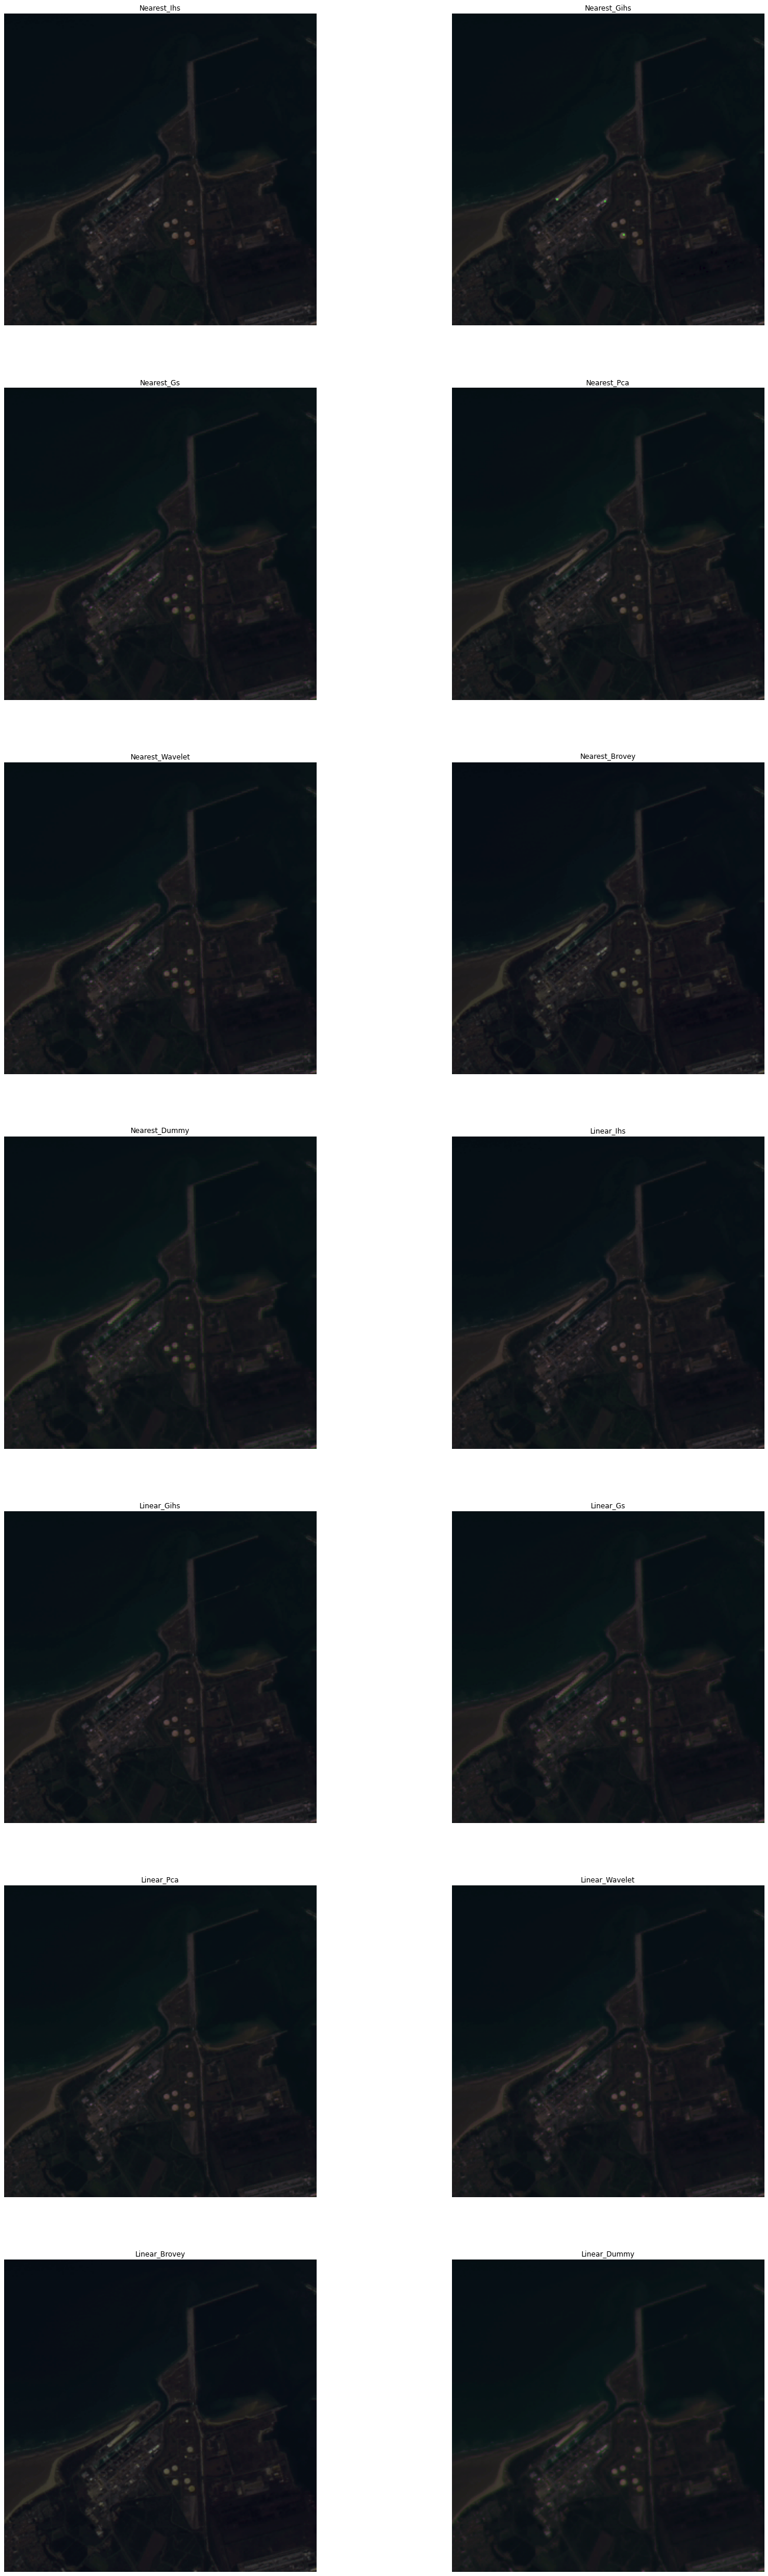

In [4]:
cols = 2
plot(
    imgs=panned,
    subplots_shape = [np.ceil(len(panned_names)/cols).astype(int),cols],
    figsize1=25,figsize2=80,
    brightness=0.1, 
    contrast=0.1,
    colorbar=False, 
    titles=["_".join(i) for i in panned_names],
    save="Visuals/demo_imgs.jpg"
)

In [5]:
panned_results = pd.DataFrame(panned_results, index = panned_names)
panned_results["interpolation"] = panned_results.index.str[0]
panned_results["method"] = panned_results.index.str[1]
panned_results

,RMSEs,ERGAS,RASE,SAM,Q2N,interpolation,method
"(Nearest, Ihs)","[1.7501238051444628, 1.79100220236852, 1.97304...",21.644389,3.030484,70.303432,0.951165,Nearest,Ihs
"(Nearest, Gihs)","[1.499110847580436, 1.5093339222613693, 1.6948...",18.261551,2.585392,70.310388,0.959813,Nearest,Gihs
"(Nearest, Gs)","[1.0374755686547783, 1.1850175807415968, 1.595...",15.310086,2.119850,70.312242,0.975064,Nearest,Gs
"(Nearest, Pca)","[1.1365053648991035, 1.3609310538500228, 1.928...",17.834527,2.465018,70.318353,0.967569,Nearest,Pca
"(Nearest, Wavelet)","[1.5796764788328583, 1.8203784710267745, 2.198...",22.349918,3.096895,70.298575,0.948508,Nearest,Wavelet
"(Nearest, Brovey)","[2.553072223376726, 2.4295221295097886, 2.2640...",28.781405,3.951398,70.308375,0.955064,Nearest,Brovey
"(Nearest, Dummy)","[1.4505324692830714, 1.7537895477444772, 2.305...",21.930195,3.061453,70.313219,0.948204,Nearest,Dummy
"(Linear, Ihs)","[2.072733032067136, 2.1443362091280784, 2.3646...",25.864499,3.621169,70.304032,0.923385,Linear,Ihs
"(Linear, Gihs)","[1.8862543719115816, 1.9598185857086081, 2.179...",23.430102,3.316854,70.311024,0.929921,Linear,Gihs
"(Linear, Gs)","[1.1865168444747096, 1.3145003275431737, 1.662...",16.492886,2.306416,70.312844,0.967505,Linear,Gs


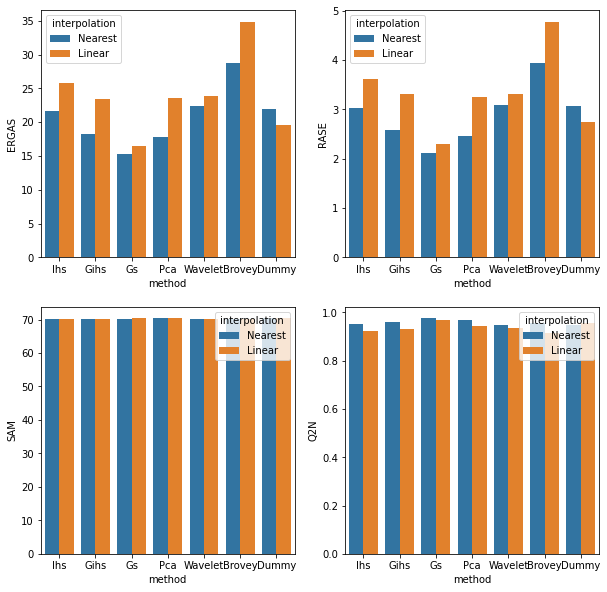

In [6]:
qualities = [col for col in panned_results.columns if col not in ["interpolation", 'method', 'RMSEs']]
ncols = 2
nrows = np.ceil(len(qualities)/ncols).astype(int)
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(10,10))

qualities_index = 0
for i in range(ncols):
    for j in range(nrows):
        sns.barplot(ax=axes[i,j], x="method", y=qualities[qualities_index], hue="interpolation", data=panned_results)
        qualities_index +=1
        
fig.savefig(
    "Visuals/demo_stats.jpg",
    bbox_inches='tight', 
    transparent=True,
    pad_inches=0.1)